## 2. 自然言語と単語の分散表現
- DL登場以前の手法について詳しく見ていく

- 単語の意味を表現する方法
    - シソーラスによる手法 : 本章
    - カウントベースの手法 : 本章
    - 推論ベースの手法(word2vec) : 次章

- シソーラス
    - 単語の意味ネットワークを辞書として使う
    - WordNet
        - 1985年にプリンストン大学で開発がスタート
- シソーラスの問題点
    - 人力で意味ネットワークを作るので作業コストが高い
    - 時代の変化などに対応するのが困難
    - 単語の細かなニュアンスが把握できない

- カウントベース
    - コーパスを利用する
        - コーパスは，NLPの研究やアプリケーションの開発のために収集された大量のテキストデータ

In [11]:
from rich import print
import numpy as np

#
# コーパスの下準備
#

# テキストから単語への分割
# 小さなテキストでやってみる(本来は何千，何万を超えるテキスト)
text = 'You say goodbye and I say hello.'
text = text.lower().replace('.', ' .')
words = text.split(' ')
print(words)

word2id = {}
id2word = {}
for word in words:
    if word not in word2id:
        new_id = len(word2id)
        word2id[word] = new_id
        id2word[new_id] = word
print(f"word2id: {word2id}")
print(f"id2word: {id2word}")

# 単語のリストを単語のIDリストに変換
corpus = np.array([word2id[w] for w in words])
print(corpus)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

word2id: {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

id2word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

[0 1 2 3 4 1 5 6]

In [12]:
#
# 関数化しておく
# 

def preprocess(text):
    """
    文章からコーパス，単語→ID，ID→単語リストの作成
    """
    text = text.lower().replace('.', ' .')
    words = text.split(' ')
    word2id = {}
    id2word = {}
    for word in words:
        if word not in word2id:
            new_id = len(word2id)
            word2id[word] = new_id
            id2word[new_id] = word
    # 単語リスト → IDリスト
    corpus = np.array([word2id[w] for w in words])
    return corpus, word2id, id2word

- 単語の分散表現
    - 単語の意味はベクトルで表現できる
    - 色もRGBの3次元ベクトルで表現されるのと似たような考え方
- 分布仮説
    - 文章中の単語の意味は周囲の単語で決定されるという考え方
- 共起行列
    - 分布仮説に基づいて，単語をベクトルで表現する方法
    - ある単語に注目したとき，その周囲にどのような単語が表れるのかをカウントする
- コサイン類似度
    - ベクトルの類似度を計算

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
print(corpus)
print(id2word)

[0 1 2 3 4 1 5 6]

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [14]:
#
# 共起行列の作成
#

def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    共起行列の作成
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - 1
            right_idx = idx + 1
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

#
# コサイン類似度
#

def cos_similarity(x, y, eps=1e-8):
    """
    コサイン類似度

    eps
      ゼロベクトルが入ると分子が0にって0除算が発生する．その対策
      丸め誤差によりこの程度の誤差は他の値に吸収されるので影響はほぼ出ない
    """
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return nx @ ny

In [21]:
import pandas as pd

#
# 今までの内容をまとめて．テキストから共起行列を作るまで一気通貫で実行してみる
# 

text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)

# print(C)
# 共起行列はこんな感じになる
display(pd.DataFrame(C, index=word2id.keys(), columns=word2id.keys()))

c0 = C[word2id['you']]
c1 = C[word2id['i']]
print(cos_similarity(c0, c1))

,you,say,goodbye,and,i,hello,.
you,0,1,0,0,0,0,0
say,1,0,1,0,1,1,0
goodbye,0,1,0,1,0,0,0
and,0,0,1,0,1,0,0
i,0,1,0,1,0,0,0
hello,0,1,0,0,0,0,1
.,0,0,0,0,0,1,0


0.7071067758832467

In [24]:
#
# 類似単語のランキング表示
#

def most_similar(query, word2id, id2word, word_matrix, top=5):
    """
    与えられた単語と類似度が高い単語を返す

    query: 類似度を求めたい単語
    word2id:
    id2word:
    word_matrix: 共起行列
    top:
    """

    if query not in word2id:
        print(f"{query} is not found")
        return
    print(f"[query] {query}")
    query_id = word2id[query]
    query_vec = word_matrix[query_id]
    vocab_size = len(word2id)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    count = 0
    for i in (-1 * similarity).argsort():
        if id2word[i] == query:
            continue
        print(f"{id2word[i]}: {similarity[i]}")
        count += 1
        if count >= top:
            return

In [25]:
text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word2id, id2word, C, top=5)

you

goodbye: 0.7071067758832467

i: 0.7071067758832467

hello: 0.7071067758832467

say: 0.0

and: 0.0

- 相互情報量
    - 単なるカウントベースだと上手く単語同士の関連性を表現することができない
    - コーパスの単語数を$N$として，単語$x, y$が出現した回数を$C(x), C(y)$としたとき，単語$x, y$が出現する確率は$P(x), P(y)$と書く
        - $P(x) = \frac{C(x)}{N}$
    - さらに，単語$x, y$が共起する確率は$P(x,y)$と書く
    - このとき相互情報量PMIは以下で書く
        - $PMI = \log_{2}\frac{P(x,y)}{P(x)P(y)} = \log_{2}\frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}} = \log_{2}\frac{C(x,y)\cdot N}{C(x)C(y)}$
- 正の相互情報量
    - $\log_{2}0 = -\infty$ となるので，実践的に正の相互情報量を使う
    - $PPMI(x,y) = max(0, PMI(x,y))$

In [48]:
def ppmi(C, verbose=False, eps=1e-7):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) # 全単語数
    S = np.sum(C, axis=0) # ↓方向でsum
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j]*N / (S[i]*S[j]+eps))
            M[i,j] = max(0,pmi)
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print(f"{100*cnt/total:.1f}% done")
    return M

In [39]:
text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

pd.options.display.float_format = "{: .3f}".format
print('convariance matrix')
# print(C)
display(pd.DataFrame(C, index=word2id.keys(), columns=word2id.keys()))
print('-'*50)
print('PPMI')
# print(W)
display(pd.DataFrame(W, index=word2id.keys(), columns=word2id.keys()))
pd.options.display.float_format = None

/tmp/ipykernel_4984/492258848.py:9: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(C[i,j]*N / (S[i]*S[j]+eps))


convariance matrix

,you,say,goodbye,and,i,hello,.
you,0,1,0,0,0,0,0
say,1,0,1,0,1,1,0
goodbye,0,1,0,1,0,0,0
and,0,0,1,0,1,0,0
i,0,1,0,1,0,0,0
hello,0,1,0,0,0,0,1
.,0,0,0,0,0,1,0


--------------------------------------------------

PPMI

,you,say,goodbye,and,i,hello,.
you,0.000,1.807,0.000,0.000,0.000,0.000,0.000
say,1.807,0.000,0.807,0.000,0.807,0.807,0.000
goodbye,0.000,0.807,0.000,1.807,0.000,0.000,0.000
and,0.000,0.000,1.807,0.000,1.807,0.000,0.000
i,0.000,0.807,0.000,1.807,0.000,0.000,0.000
hello,0.000,0.807,0.000,0.000,0.000,0.000,2.807
.,0.000,0.000,0.000,0.000,0.000,2.807,0.000


- これにより，共起行列をPPMIに変換することができた
- ただし，この方法も完全ではない
    - コーパスのサイズが10万になれば共起行列のサイズも10万×10万になる
    - 次元削減をするととで解決
- 次元削減
    - ベクトルの次元を削減する
    - 特異値分解を用いる
- 特異値分解
    - 数値は省く
    - np.linalg.svd(W)で利用可能

In [40]:
text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

print(C[0])
print(W[0])
print(U[0])

/tmp/ipykernel_4984/492258848.py:9: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(C[i,j]*N / (S[i]*S[j]+eps))


[0 1 0 0 0 0 0]

[0.        1.8073549 0.        0.        0.        0.        0.       ]

[-1.11022302e-16  3.40948761e-01 -4.16333634e-16 -1.20516241e-01
 -1.11022302e-16 -9.32324946e-01 -1.08553466e-16]

- 疎な行列が密な行列に変換されていることが確認できる
- 使いたい分の次元数は`U[0, :2]`などと指定すれば，2次元への圧縮を意味する

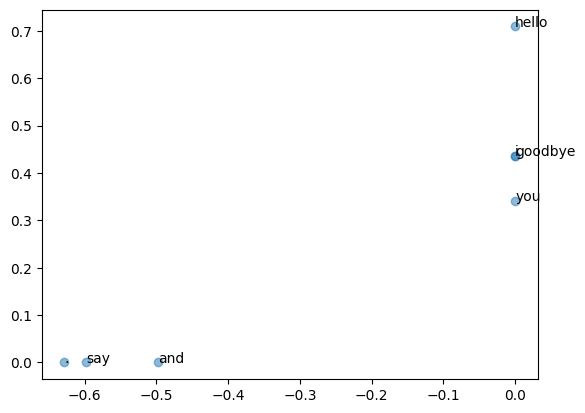

In [43]:
#
# 7次元の共起行列，PPMIを2次元に削減してプロットしてみる
#

# 小さなコーパスなので微妙ではあるが，i, goodbye, hello, youが近い意味を持つなどと解釈できる

import matplotlib.pyplot as plt

for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

- PTB(Penn Treebank)データセット
    - 本格的であるが，大きすぎない手ごろなコーパス
    - word2vecの開発者Tomas MikolovのWebページで公開されている
    - 具体的な数字をN，レアな単語をunkなどに置き換えている

In [ ]:
# ptb.py
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/dataset/ptb.py

# これを実行してコーパスを引っ張ってくる(中身はそんなよんでない)
# ptb. ~~ ファイルが生成される

- この章でやった処理をPTBセットで実験する

In [46]:
import ptb
corpus, word2id, id2word = ptb.load_data('train')
print(len(corpus))

929589

In [49]:
# より高速でメモリレスなSVDを使う
window_size = 2
wordvec_size = 100
vocab_size = len(word2id)
print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating SVD ...')
W = ppmi(C, verbose=False)

from sklearn.utils.extmath import randomized_svd
U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word2id, id2word, word_vecs, top=5)

counting co-occurrence ...

calculating SVD ...

/tmp/ipykernel_4984/2503955487.py:9: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(C[i,j]*N / (S[i]*S[j]+eps))


you

we: 0.843364417552948

i: 0.8225908875465393

they: 0.6780215501785278

anybody: 0.5563338994979858

nobody: 0.5393531918525696

year

week: 0.8800252079963684

month: 0.8469558954238892

quarter: 0.7162731885910034

summer: 0.7001152634620667

day: 0.6836220026016235

car

auto: 0.7198748588562012

luxury-car: 0.610831081867218

truck: 0.5892620086669922

printing: 0.5702490210533142

jewelry: 0.5668525099754333

toyota

kuwait: 0.6906740069389343

banque: 0.6158156991004944

pakistan: 0.6116858720779419

aeroflot: 0.6023983955383301

lufthansa: 0.5908816456794739

- それっぽい感じはあるという印象
- 他指標との比較とかあんま詳しくないのでピンとこない